In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.nn.utils import spectral_norm
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

import time
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.set_default_dtype(torch.float64)

In [2]:
class DNN(nn.Module):
    def __init__(self, neurons, activation, spectral=False):

        super(DNN, self).__init__()
        self.activation = activation
        self.n_layers = len(neurons)
        self.dense = {}
        self.nn_layers = nn.ModuleList()

        for i in range(self.n_layers-1):
            if spectral:
                self.dense[str(i)] = spectral_norm(nn.Linear(neurons[i], neurons[i+1]))
            else:
                self.dense[str(i)] = nn.Linear(neurons[i], neurons[i+1])
            
            if activation==torch.sin:
                c = torch.sqrt(torch.tensor(6.))
                numerator = torch.sqrt(torch.tensor(neurons[i]).double())
                nn.init.uniform_(self.dense[str(i)].weight, a=-c/numerator, b=c/numerator)
                nn.init.zeros_(self.dense[str(i)].bias)
            else:
                nn.init.xavier_uniform_(self.dense[str(i)].weight)
                nn.init.zeros_(self.dense[str(i)].bias)                
            self.nn_layers.append(self.dense[str(i)])
            
    def forward(self, *args):
        x = torch.cat(args,1)
        activation = self.activation
        for i in range(self.n_layers-2):
            x = activation(self.dense[str(i)](x))
        i = self.n_layers-2
        return self.dense[str(i)](x)

In [3]:
device='cuda'
torch.manual_seed(0)

dim_x = 1
dim_z = 2
B_size=32
N_test = 20000
m_test = 101
x_test = torch.linspace(0,1,m_test, device=device, requires_grad=True).reshape(-1,1)
z_test = torch.randn([N_test,dim_z],device=device)

u_means = []
u_stds = []
f_means = []
b_means = []
cors = []

In [4]:
p=32
net_size_ux = [B_size,32,32,p]
net_size_uz = [B_size,32,32,p]

def FEx(x):
    x_sin = torch.sin(torch.matmul(x,B_x))
    x_cos = torch.cos(torch.matmul(x,B_x))
    return torch.concat([x_cos,x_sin],-1)

def FEz(x):
    x_sin = torch.sin(torch.matmul(x,B_z))
    x_cos = torch.cos(torch.matmul(x,B_z))
    return torch.concat([x_cos,x_sin],-1)

acti = torch.sin
ux = DNN(net_size_ux, activation=acti).to(device)
uz = DNN(net_size_uz, activation=acti).to(device)

def GU(X, Z):
    X_FE = FEx(X)
    Z = FEz(Z)
    outx = acti(ux(X_FE))
    outz = uz(Z)
    out = torch.matmul(outz,outx.T)
    return out

def b_tilde(X,Z):
    return GU(X,Z)

def f_tilde(X,Z):
    u = GU(X,Z)
    
    dummy = torch.ones(u.shape, device=device, requires_grad=True)
    tmp = grad(u, X, grad_outputs=dummy, create_graph=True)[0]
    u_x = grad(tmp[:,0].sum(), dummy, create_graph=True)[0]
    return u_x

save_path='WGANSN_PCN_SD'
with open(save_path+'/B_x.pickle', 'rb') as f:
    B_x = pickle.load(f)
with open(save_path+'/B_z.pickle', 'rb') as f:
    B_z = pickle.load(f)
ux.load_state_dict(torch.load(save_path+'/paramsux'))
uz.load_state_dict(torch.load(save_path+'/paramsuz'))

with torch.no_grad():
    u_gen = GU(x_test, z_test).cpu()
    u_means.append(u_gen.mean(0))
    u_stds.append(u_gen.std(0))
    
f_gen = f_tilde(x_test,z_test).cpu().detach()
b_gen = b_tilde(torch.zeros([1,1], device=device), z_test).cpu().detach()
cor = (b_gen-b_gen.mean(0))*(f_gen-f_gen.mean(0))
f_means.append(f_gen.mean(0))
b_means.append(b_gen.mean(0))
cors.append(cor.mean(0))
    
save_path='WGANSN_PCN_MD'
with open(save_path+'/B_x.pickle', 'rb') as f:
    B_x = pickle.load(f)
with open(save_path+'/B_z.pickle', 'rb') as f:
    B_z = pickle.load(f)
ux.load_state_dict(torch.load(save_path+'/paramsux'))
uz.load_state_dict(torch.load(save_path+'/paramsuz'))

with torch.no_grad():
    u_gen = GU(x_test, z_test).cpu()
    u_means.append(u_gen.mean(0))
    u_stds.append(u_gen.std(0))
    
f_gen = f_tilde(x_test,z_test).cpu().detach()
b_gen = b_tilde(torch.zeros([1,1], device=device), z_test).cpu().detach()
cor = (b_gen-b_gen.mean(0))*(f_gen-f_gen.mean(0))
cor = cor.detach()
f_means.append(f_gen.mean(0))
b_means.append(b_gen.mean(0))
cors.append(cor.mean(0))

In [5]:
colors_ = [plt.cm.Paired(i) for i in range(20)]
x_test_ = x_test.flatten().cpu().detach()

color_ref = 'k'
colors = [colors_[1],colors_[5]]
labels = ['SD','MD']
linetypes = ['--', ':']
markertypes = ['^','s']

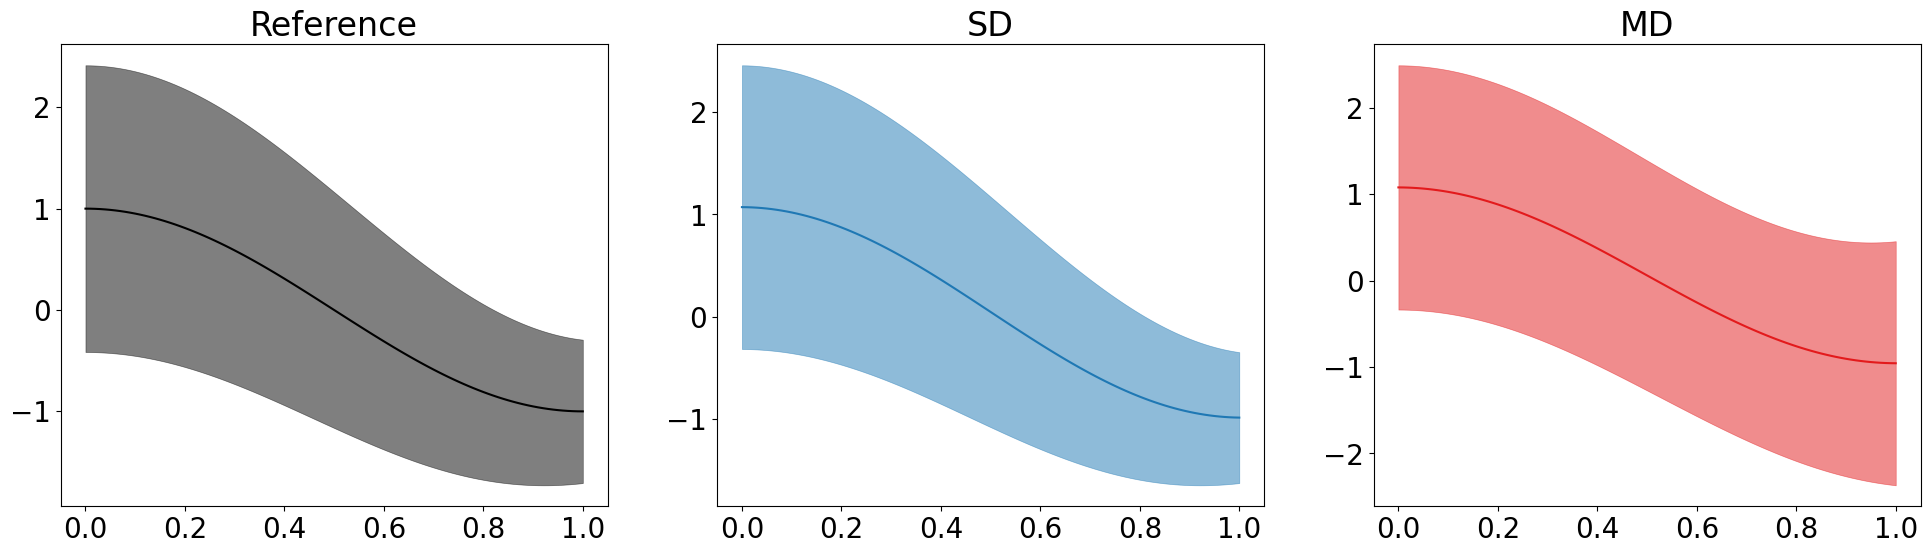

In [6]:
u_mean_ref = torch.cos(np.pi*x_test_)
u_std_ref = torch.sqrt(torch.cos(np.pi/2*x_test_)**2+torch.cos(np.pi/4*x_test_)**2)

fig = plt.figure(figsize=(24,6))
axes = [plt.subplot(1,3,1), plt.subplot(1,3,2), plt.subplot(1,3,3)]

for i in range(2):
    axes[i+1].plot(x_test_,u_means[i],'-',label=labels[i], color=colors[i])
    axes[i+1].fill_between(x_test_, u_means[i]+u_stds[i], u_means[i]-u_stds[i], alpha=0.5, linewidth=.5, color=colors[i])

axes[0].plot(x_test_.flatten(),u_mean_ref, '-',label='exact', color='k')
axes[0].fill_between(x_test_, u_mean_ref+u_std_ref, u_mean_ref-u_std_ref, alpha=0.5, linewidth=.5, color='k')

axes[0].set_title('Reference')
axes[1].set_title('SD')
axes[2].set_title('MD')

fig.savefig('images/ODEu.pdf', bbox_inches='tight')

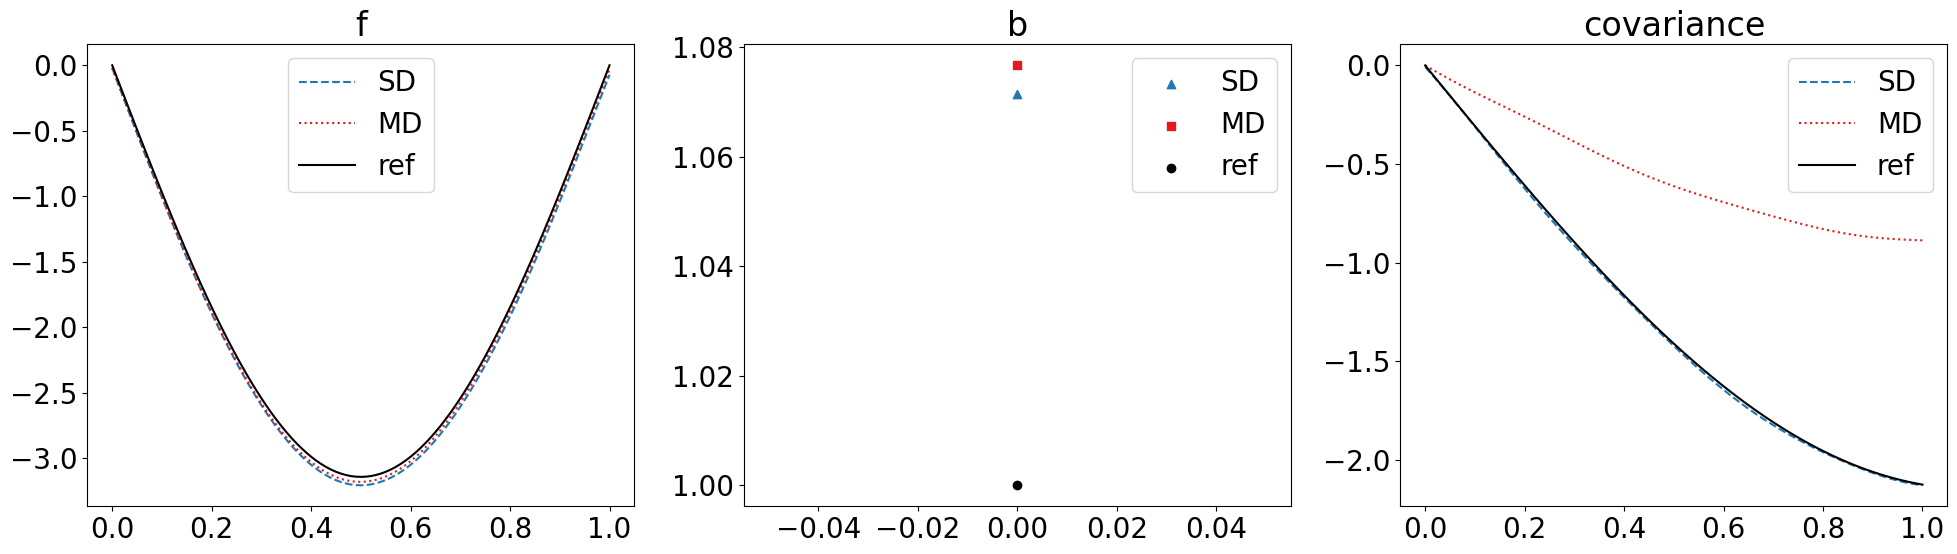

In [8]:
f_mean_ref = -np.pi*torch.sin(np.pi*x_test_)
# f_std_ref = torch.sqrt((np.pi/2*torch.sin(np.pi/2*x_test_))**2+(np.pi/4*torch.sin(np.pi/4*x_test_))**2)
b_mean_ref = torch.ones([1,1])
cor_ref = -np.pi/2*torch.sin(np.pi/2*x_test_)-np.pi/4*torch.sin(np.pi/4*x_test_)

fig = plt.figure(figsize=(24,6))
axes = [plt.subplot(1,3,1), plt.subplot(1,3,2), plt.subplot(1,3,3)]

for i in range(2):
    axes[0].plot(x_test_,f_means[i],linetypes[i],label=labels[i], color=colors[i])
    axes[1].scatter(torch.zeros([1]),b_means[i],marker=markertypes[i],label=labels[i], color=colors[i])
    axes[2].plot(x_test_,cors[i],linetypes[i],label=labels[i], color=colors[i])

axes[0].plot(x_test_,f_mean_ref,'-',label='ref', color=color_ref)
axes[1].scatter(torch.zeros([1]),b_mean_ref,label='ref', color=color_ref)
axes[2].plot(x_test_,cor_ref,'-',label='ref', color=color_ref)

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].set_title('f')
axes[1].set_title('b')
axes[2].set_title('covariance')

fig.savefig('images/ODEfbcor.pdf', bbox_inches='tight')

In [ ]:
!kill -9 {os.getpid()}